# VQO of the Mutual Information of the Magic Squares MAC

The magic squares nonlocal game can be embedded into a multiple access channel (MAC) (see https://arxiv.org/pdf/1909.02479.pdf).
In this setting, the MAC is classical and serves as a white-box verifier for the nonlocal game.
If the nonlocal game is won by Alice and Bob, the MAC verifier outputs the inputs $x_1$ and $x_2$ otherwise, the MAC verifier outputs $\hat{x}_1$ and $\hat{x}_2$ drawn from the uniform distribution (i.e. noise).


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Mutual Information as a Cost Function

For the magic square game, the MAC mutual information is expressed as $I(\hat{x}_1,\hat{x}_2;x_1,x_2,y_1,y_2) = H(P(\hat{x}_1,\hat{x}_2)) - P_{Lose}\log_2(9)$ where $H(P(\hat{x}_1, \hat{x}_2))$ is the shannon entropy of the joint distribution.
To cast the mutual information as a cost function we simply take the negative of it, $-I(\hat{x}_1,\hat{x}_2;x_1,x_2,y_1,y_2)$.

In our cost function, we compute $H(P(\hat{x}_1, \hat{x}_2))$ where $P(\hat{x}_1, \hat{x}_2) = \frac{1}{9}\left(P(win|x_1,x_2) + P_{Lose}\right)$. This holds true as long as we have a uniform distribution over inputs.

In [2]:
def shannon_entropy(probs):
    return sum([-p*np.log2(p) for p in np.where(probs == 0, 1, probs)])
    
# This is a factory function to create a cost function based upon the
# quantum circuit expressed in probs_qnode
def magic_squares_mutual_information_cost(probs_qnode):
    
    def cost(settings, **kwargs):
        state_settings, A_settings, B_settings = settings
        
        p_win = 0
        z_probs_list = []
        for x1 in [0,1,2]:
            for x2 in [0,1,2]:
                probs = probs_qnode(state_settings, A_settings[x1], B_settings[x2])
    
                p_x1x2_win = 0

                for i in range(16):
                    bit_string = [int(j) for j in np.binary_repr(i,4)]

                    A_parity_bit = 0 if (bit_string[0] + bit_string[1]) % 2 == 0 else 1
                    B_parity_bit = 1 if (bit_string[2] + bit_string[3]) % 2 == 0 else 0

                    A_bits = bit_string[0:2] + [A_parity_bit]
                    B_bits = bit_string[2:] + [B_parity_bit]

                    if A_bits[x2] == B_bits[x1]:
                        p_x1x2_win += probs[i]
                             
                p_win += p_x1x2_win/9
                z_probs_list.append(p_x1x2_win/9)
        
        z_probs = np.ones(9)*(1-p_win)/9 + np.array(z_probs_list)
        assert np.isclose(sum(z_probs), 1)
                            
        mutual_information = shannon_entropy(z_probs) - (1-p_win)*(np.log2(9))    
        
        return -(mutual_information)
    
    return cost

# creates randomized initial settings for magic squares qnodes
def rand_magic_squares_settings(num_state_settings, num_A_settings, num_B_settings):
    state_settings = 2 * np.pi * np.random.random(num_state_settings)
    A_settings = [
        2 * np.pi * np.random.random(num_A_settings) - np.pi for i in range(3)
    ]
    B_settings = [
        2 * np.pi * np.random.random(num_B_settings) - np.pi for i in range(3)
    ]
    
    return state_settings, A_settings, B_settings

In the following cell, we create a quantum circuit ansatz for the magic square game. The initialized entangled state is set as the "ideal" quantum state.

In [3]:
def ideal_init_state():
    for i in range(4):
        qml.PauliX(wires=[i])

    for i in range(2):
        qml.Hadamard(wires=[i])
        qml.CNOT(wires=[i,i+2])

dev = qml.device("default.qubit", wires=range(4))
@qml.qnode(dev)
def measurement_qnode(state_settings, settingsA, settingsB):
    ideal_init_state()
    
    qml.templates.subroutines.ArbitraryUnitary(settingsA, wires=dev.wires[0:2])
    qml.templates.subroutines.ArbitraryUnitary(settingsB, wires=dev.wires[2:])
    
    return qml.probs(wires=dev.wires)

Performing gradient descent to minimize $-I(\hat{x}_1,\hat{x}_2;x_1,x_2,y_1,y_2)$.

In [4]:
%%time

opt = qml.GradientDescentOptimizer(stepsize=0.6)
num_steps = 150
sample_width = 10

measurement_cost = magic_squares_mutual_information_cost(measurement_qnode)

init_settings = rand_magic_squares_settings(0,15,15)
scores = []
samples = []
settings_history = []

# performing gradient descent
for i in range(num_steps):
    if i % sample_width == 0:
        score = -(measurement_cost(init_settings))
        scores.append(score)
        samples.append(i)

        print("iteration : ", i, ", score : ", score)

    # updating settings
    init_settings = opt.step(measurement_cost, init_settings)
    settings_history.append(init_settings)

opt_score = -(measurement_cost(init_settings))

scores.append(opt_score)
samples.append(num_steps - 1)

print("final score : ", opt_score)

iteration :  0 , score :  1.5370320096297105
iteration :  10 , score :  2.544794870519551
iteration :  20 , score :  2.928870553918306
iteration :  30 , score :  3.0943835054553768
iteration :  40 , score :  3.140873437571082
iteration :  50 , score :  3.1559531492942896
iteration :  60 , score :  3.1619767598006807
iteration :  70 , score :  3.1649394522717085
iteration :  80 , score :  3.166616312529547
iteration :  90 , score :  3.1676490201395398
iteration :  100 , score :  3.168319839708334
iteration :  110 , score :  3.1687718288450206
iteration :  120 , score :  3.1690846542438234
iteration :  130 , score :  3.1693056531605155
iteration :  140 , score :  3.169464322170091
final score :  3.169579727615636
CPU times: user 46.8 s, sys: 393 ms, total: 47.1 s
Wall time: 47.4 s


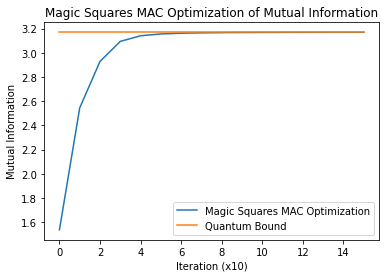

In [5]:
plt.plot(range(16), scores , label = "Magic Squares MAC Optimization")
plt.plot(range(16), [np.log2(9)]*len(scores), label = "Quantum Bound")
plt.title("Magic Squares MAC Optimization of Mutual Information")
plt.xlabel("Iteration (x10)")
plt.ylabel("Mutual Information")
plt.legend()
plt.show()

## Local Quantum States do not Achieve Optimal Mutual Information 


In [6]:
dev2 = qml.device("default.qubit", wires=range(4))
@qml.qnode(dev2)
def local_measurement_qnode(state_settings, settingsA, settingsB): 
    # encode local measurments 
    qml.templates.subroutines.ArbitraryUnitary(settingsA, wires=dev2.wires[0:2])
    qml.templates.subroutines.ArbitraryUnitary(settingsB, wires=dev2.wires[2:])
    
    return qml.probs(wires=dev2.wires)

In [7]:
%%time

opt = qml.GradientDescentOptimizer(stepsize=0.6)
num_steps = 150
sample_width = 10

local_measurement_cost = magic_squares_mutual_information_cost(local_measurement_qnode)

local_init_settings = rand_magic_squares_settings(0,15,15)
scores = []
samples = []
settings_history = []

# performing gradient descent
for i in range(num_steps):
    if i % sample_width == 0:
        score = -(local_measurement_cost(local_init_settings))
        scores.append(score)
        samples.append(i)

        print("iteration : ", i, ", score : ", score)

    # updating settings
    local_init_settings = opt.step(local_measurement_cost, local_init_settings)
    settings_history.append(local_init_settings)

local_opt_score = -(local_measurement_cost(local_init_settings))
local_opt_settings = local_init_settings

scores.append(local_opt_score)
samples.append(num_steps - 1)

print("final score : ", local_opt_score)

iteration :  0 , score :  1.7647924811787938
iteration :  10 , score :  2.565842239262902
iteration :  20 , score :  2.7738456005169048
iteration :  30 , score :  2.789137037465492
iteration :  40 , score :  2.794150210267
iteration :  50 , score :  2.7964223021402046
iteration :  60 , score :  2.797497966475083
iteration :  70 , score :  2.79803969971349
iteration :  80 , score :  2.798340610258796
iteration :  90 , score :  2.7985261529777326
iteration :  100 , score :  2.79865085043938
iteration :  110 , score :  2.798740013754271
iteration :  120 , score :  2.798806570861369
iteration :  130 , score :  2.798857808195635
iteration :  140 , score :  2.798898186231431
final score :  2.7989306084798953
CPU times: user 47.2 s, sys: 486 ms, total: 47.7 s
Wall time: 49 s


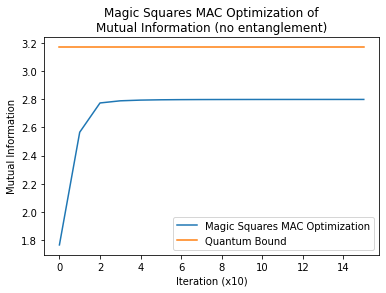

In [8]:
plt.plot(range(16), scores , label = "Magic Squares MAC Optimization")
plt.plot(range(16), [np.log2(9)]*len(scores), label = "Quantum Bound")
plt.title("Magic Squares MAC Optimization of\nMutual Information (no entanglement)")
plt.xlabel("Iteration (x10)")
plt.ylabel("Mutual Information")
plt.legend()
plt.show()

### scratch work

Verifying that the local quantum strategy is not a perfect winning strategy.

In [9]:
dev3 = qml.device("default.qubit", wires=range(4), shots=10)
@qml.qnode(dev3)
def local_measurement_samples_qnode(state_settings, settingsA, settingsB): 
    # encode local measurments 
    qml.templates.subroutines.ArbitraryUnitary(settingsA, wires=dev3.wires[0:2])
    qml.templates.subroutines.ArbitraryUnitary(settingsB, wires=dev3.wires[2:])
    
    return [
        qml.sample(qml.PauliZ(dev3.wires[0])),
        qml.sample(qml.PauliZ(dev3.wires[1])),
        qml.sample(qml.PauliZ(dev3.wires[2])),
        qml.sample(qml.PauliZ(dev3.wires[3]))
    ]
 

In [10]:
for x in [0,1,2]:
    for y in [0,1,2]:
        print("case : x = ", x, ", y = ", y)
        
        samplesxy = local_measurement_samples_qnode(
            local_opt_settings[0],
            local_opt_settings[1][x],
            local_opt_settings[2][y]
        )
        
        print("Alice's answers :")
        if y == 2:
            print([ 1 if samplesxy[0,i] == samplesxy[1,i] else -1 for i in range(10) ])
        else:
            print(samplesxy[y])
            
        print("Bob's answers :")
        if x == 2:
            print([ -1 if samplesxy[2,i] == samplesxy[3,i] else 1 for i in range(10) ])
        else:
            print(samplesxy[x])


case : x =  0 , y =  0
Alice's answers :
[1 1 1 1 1 1 1 1 1 1]
Bob's answers :
[1 1 1 1 1 1 1 1 1 1]
case : x =  0 , y =  1
Alice's answers :
[1 1 1 1 1 1 1 1 1 1]
Bob's answers :
[1 1 1 1 1 1 1 1 1 1]
case : x =  0 , y =  2
Alice's answers :
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bob's answers :
[1 1 1 1 1 1 1 1 1 1]
case : x =  1 , y =  0
Alice's answers :
[1 1 1 1 1 1 1 1 1 1]
Bob's answers :
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
case : x =  1 , y =  1
Alice's answers :
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Bob's answers :
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
case : x =  1 , y =  2
Alice's answers :
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Bob's answers :
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
case : x =  2 , y =  0
Alice's answers :
[-1  1 -1 -1  1 -1 -1 -1 -1 -1]
Bob's answers :
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
case : x =  2 , y =  1
Alice's answers :
[ 1  1  1  1  1 -1 -1 -1  1  1]
Bob's answers :
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
case : x =  2 , y =  2
Alice's answers :
[-1, 1, -1, -1, 1, 1, -1, 1, 1, -1]